# `grid()` Function Examples

The `grid()` function has an option to pass in a custom population function which receives the x and y indices of the current cell. This can be used to create specific scenarios.

## Central City

Let's construct a scenario with a large central population and smaller outlying populations.

In [1]:
from laser.core.utils import grid

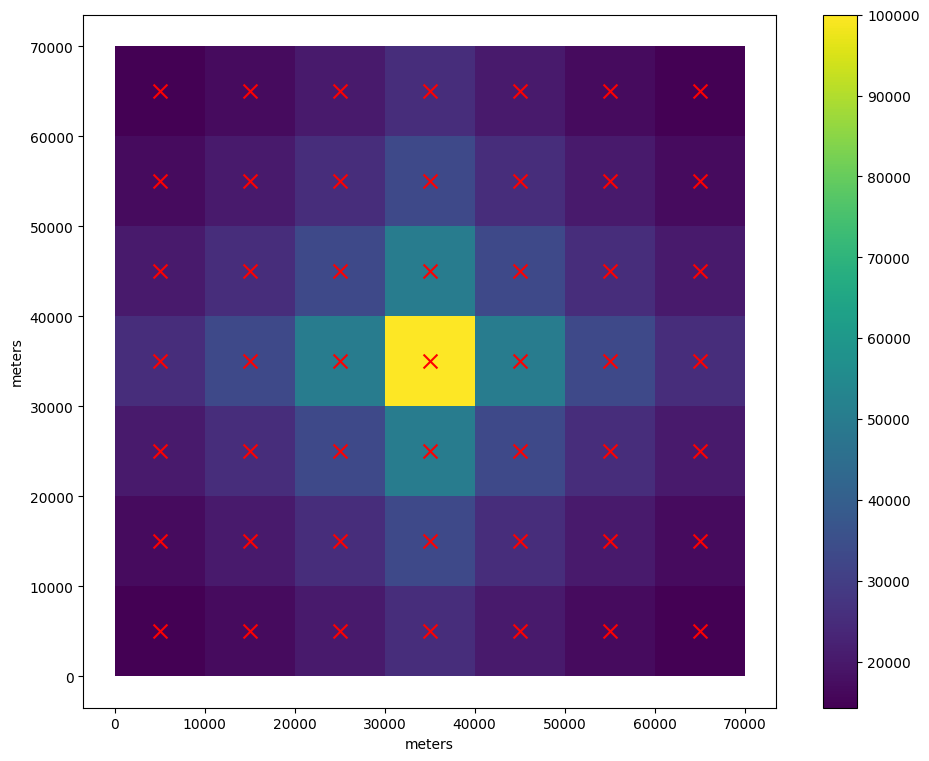

In [2]:
M = 7
CY = M // 2
N = 7
CX = N // 2

def central_pop(x, y):
    d = abs(x - CX) + abs(y - CY) + 1
    p = 1_000_000 / (10 * d)
    return int(p)

scenario = grid(M, N, population_fn=central_pop)
prj = scenario.to_crs(3857)
ax = prj.plot(column="population", cmap="viridis", legend=True, figsize=(12, 9))
prj.centroid.plot(ax=ax, color="red", marker="x", markersize=100)
_ = ax.set_xlabel("meters")
_ = ax.set_ylabel("meters")

## Ring

Let's construct a scenario with an outer ring of highly populated nodes.

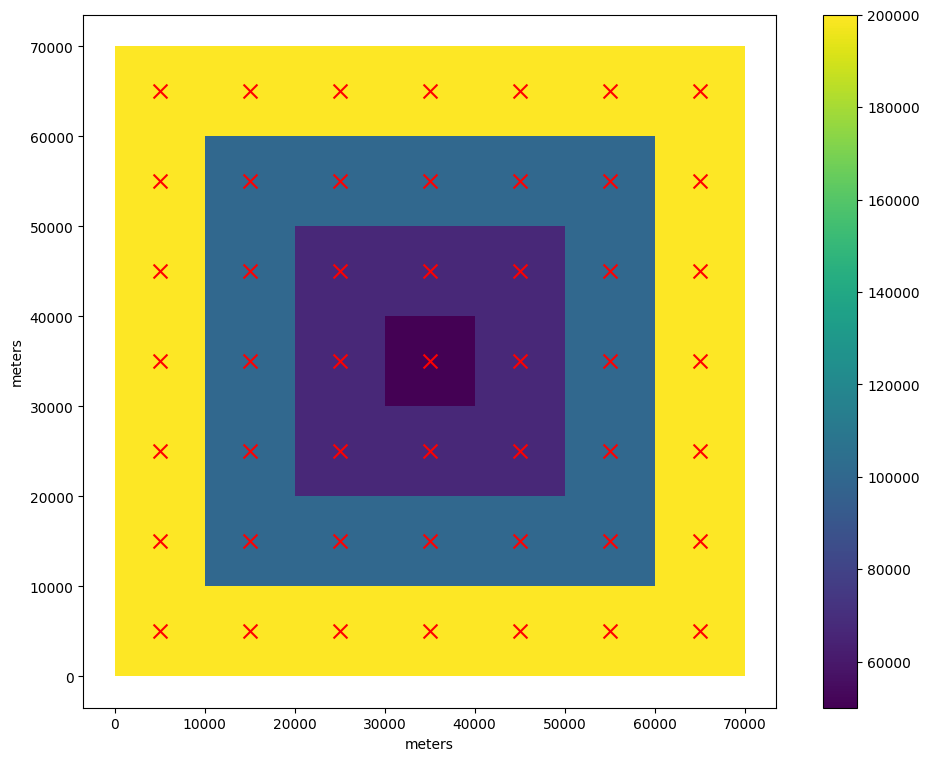

In [3]:
LEFT = 0
RIGHT = N - 1
TOP = M - 1
BOTTOM = 0

def ring_pop(x, y):

    dx = min(x - LEFT, RIGHT - x)
    dy = min(y - BOTTOM, TOP - y)
    d = min(dx, dy) + 1

    pop = int(round(1_000_000 / (5 * d)))

    return pop

scenario = grid(M, N, population_fn=ring_pop)
prj = scenario.to_crs(3857)
ax = prj.plot(column="population", cmap="viridis", legend=True, figsize=(12, 9))
prj.centroid.plot(ax=ax, color="red", marker="x", markersize=100)
_ = ax.set_xlabel("meters")
_ = ax.set_ylabel("meters")

## Linear

Let's do a 1-D scenario.

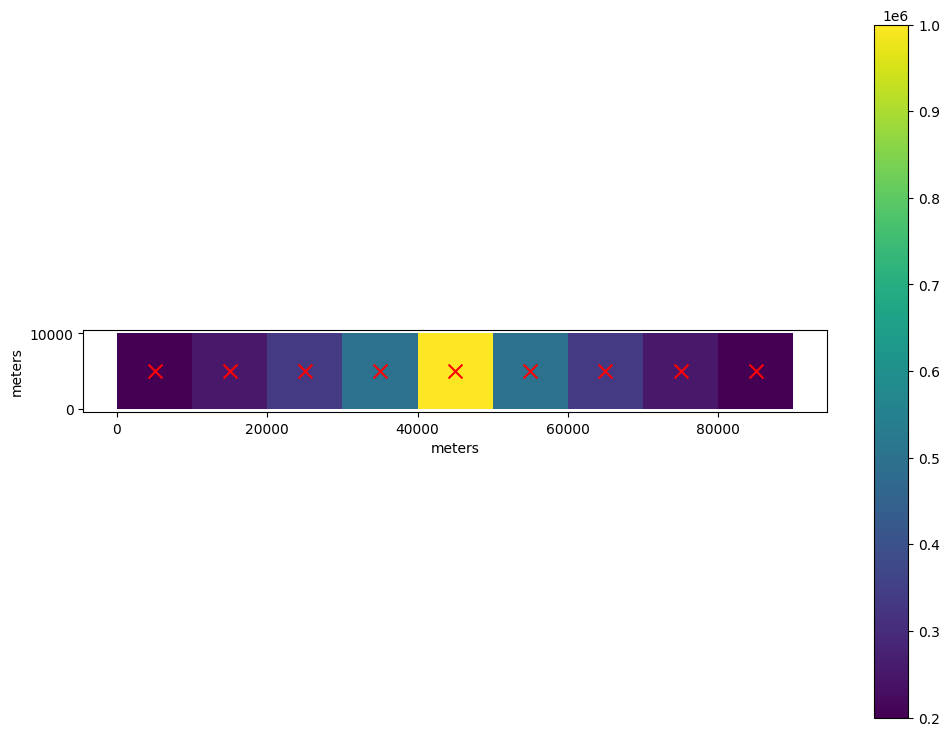

In [4]:
ROWS = 1
CY = ROWS // 2
COLUMNS = 9
CX = COLUMNS // 2

def linear_pop(row, col):
    d = abs(col - CX) + 1
    pop = int(round(1_000_000 / d))
    return pop

scenario = grid(ROWS, COLUMNS, population_fn=linear_pop)
prj = scenario.to_crs(3857)
ax = prj.plot(column="population", cmap="viridis", legend=True, figsize=(12, 9))
prj.centroid.plot(ax=ax, color="red", marker="x", markersize=100)
_ = ax.set_xlabel("meters")
_ = ax.set_ylabel("meters")

## Non-`grid()` Custom Scenario

Let's look at the GeoDataFrame returned by `grid()` and create our own, custom hub-and-spoke scenario.

In [5]:
scenario.head()


,nodeid,population,geometry
0,0,200000,"POLYGON ((0 0, 0.08983 0, 0.08983 0.08983, 0 0..."
1,1,250000,"POLYGON ((0.08983 0, 0.17966 0, 0.17966 0.0898..."
2,2,333333,"POLYGON ((0.17966 0, 0.26949 0, 0.26949 0.0898..."
3,3,500000,"POLYGON ((0.26949 0, 0.35932 0, 0.35932 0.0898..."
4,4,1000000,"POLYGON ((0.35932 0, 0.44915 0, 0.44915 0.0898..."


In [6]:
import geopandas as gpd
from shapely import Point
import math

# We will create a central city of 1,000,000 population with five surrounding towns of 100,000 population each 150 kilometers away.
# Each surrounding town will have two intermediate population centers of 25,000 between it and the central city.
nodes = []
nodeid = 0
# Add central city node at 0,0 with a circle geometry of radius 10 km
nodes.append({"name": "Central City", "population": 1_000_000, "geometry": Point(0, 0).buffer(10_000), "nodeid": nodeid})
nodeid += 1
# Surrounding towns
NTOWNS  = 5
for i in range(NTOWNS):
    angle = (i * 2 * math.pi / NTOWNS)
    tx = 150_000 * (cos := math.cos(angle))
    ty = 150_000 * (sin := math.sin(angle))
    nodes.append({"name": f"Town {i+1}", "population": 100_000, "geometry": Point(tx, ty).buffer(10_000), "nodeid": nodeid})
    nodeid += 1
    # Intermediate population centers
    ix1 = 50_000 * cos
    iy1 = 50_000 * sin
    nodes.append({"name": f"Interim {i+1}a", "population": 25_000, "geometry": Point(ix1, iy1).buffer(5_000), "nodeid": nodeid})
    nodeid += 1
    ix2 = 100_000 * cos
    iy2 = 100_000 * sin
    nodes.append({"name": f"Interim {i+1}b", "population": 25_000, "geometry": Point(ix2, iy2).buffer(5_000), "nodeid": nodeid})
    nodeid += 1

scenario = gpd.GeoDataFrame(nodes, crs="EPSG:3857") # Mark as 3857 since we're working in meters/metres.
scenario.head()

,name,population,geometry,nodeid
0,Central City,1000000,"POLYGON ((10000 0, 9951.847 -980.171, 9807.853...",0
1,Town 1,100000,"POLYGON ((160000 0, 159951.847 -980.171, 15980...",1
2,Interim 1a,25000,"POLYGON ((55000 0, 54975.924 -490.086, 54903.9...",2
3,Interim 1b,25000,"POLYGON ((105000 0, 104975.924 -490.086, 10490...",3
4,Town 2,100000,"POLYGON ((56352.549 142658.477, 56304.396 1416...",4


<Axes: >

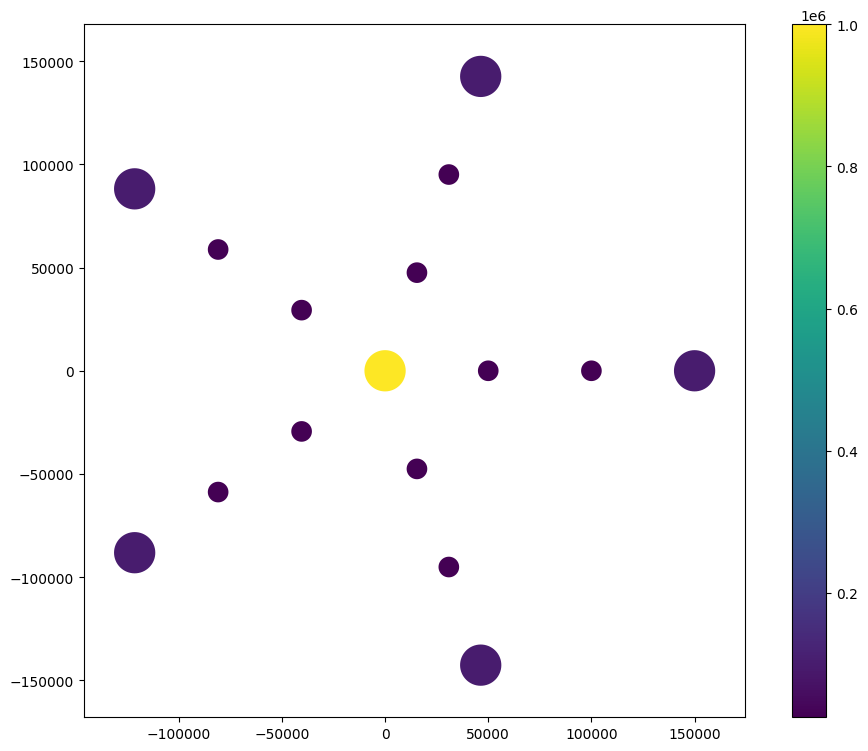

In [7]:
scenario.plot(column="population", cmap="viridis", legend=True, figsize=(12, 9))

## SEIR Model

Let's run an SEIR model on that scenario. We will seed infections in one of the radial cities.

1750000 agents in 16 nodes: 100%|██████████| 365/365 [00:01<00:00, 336.37it/s]


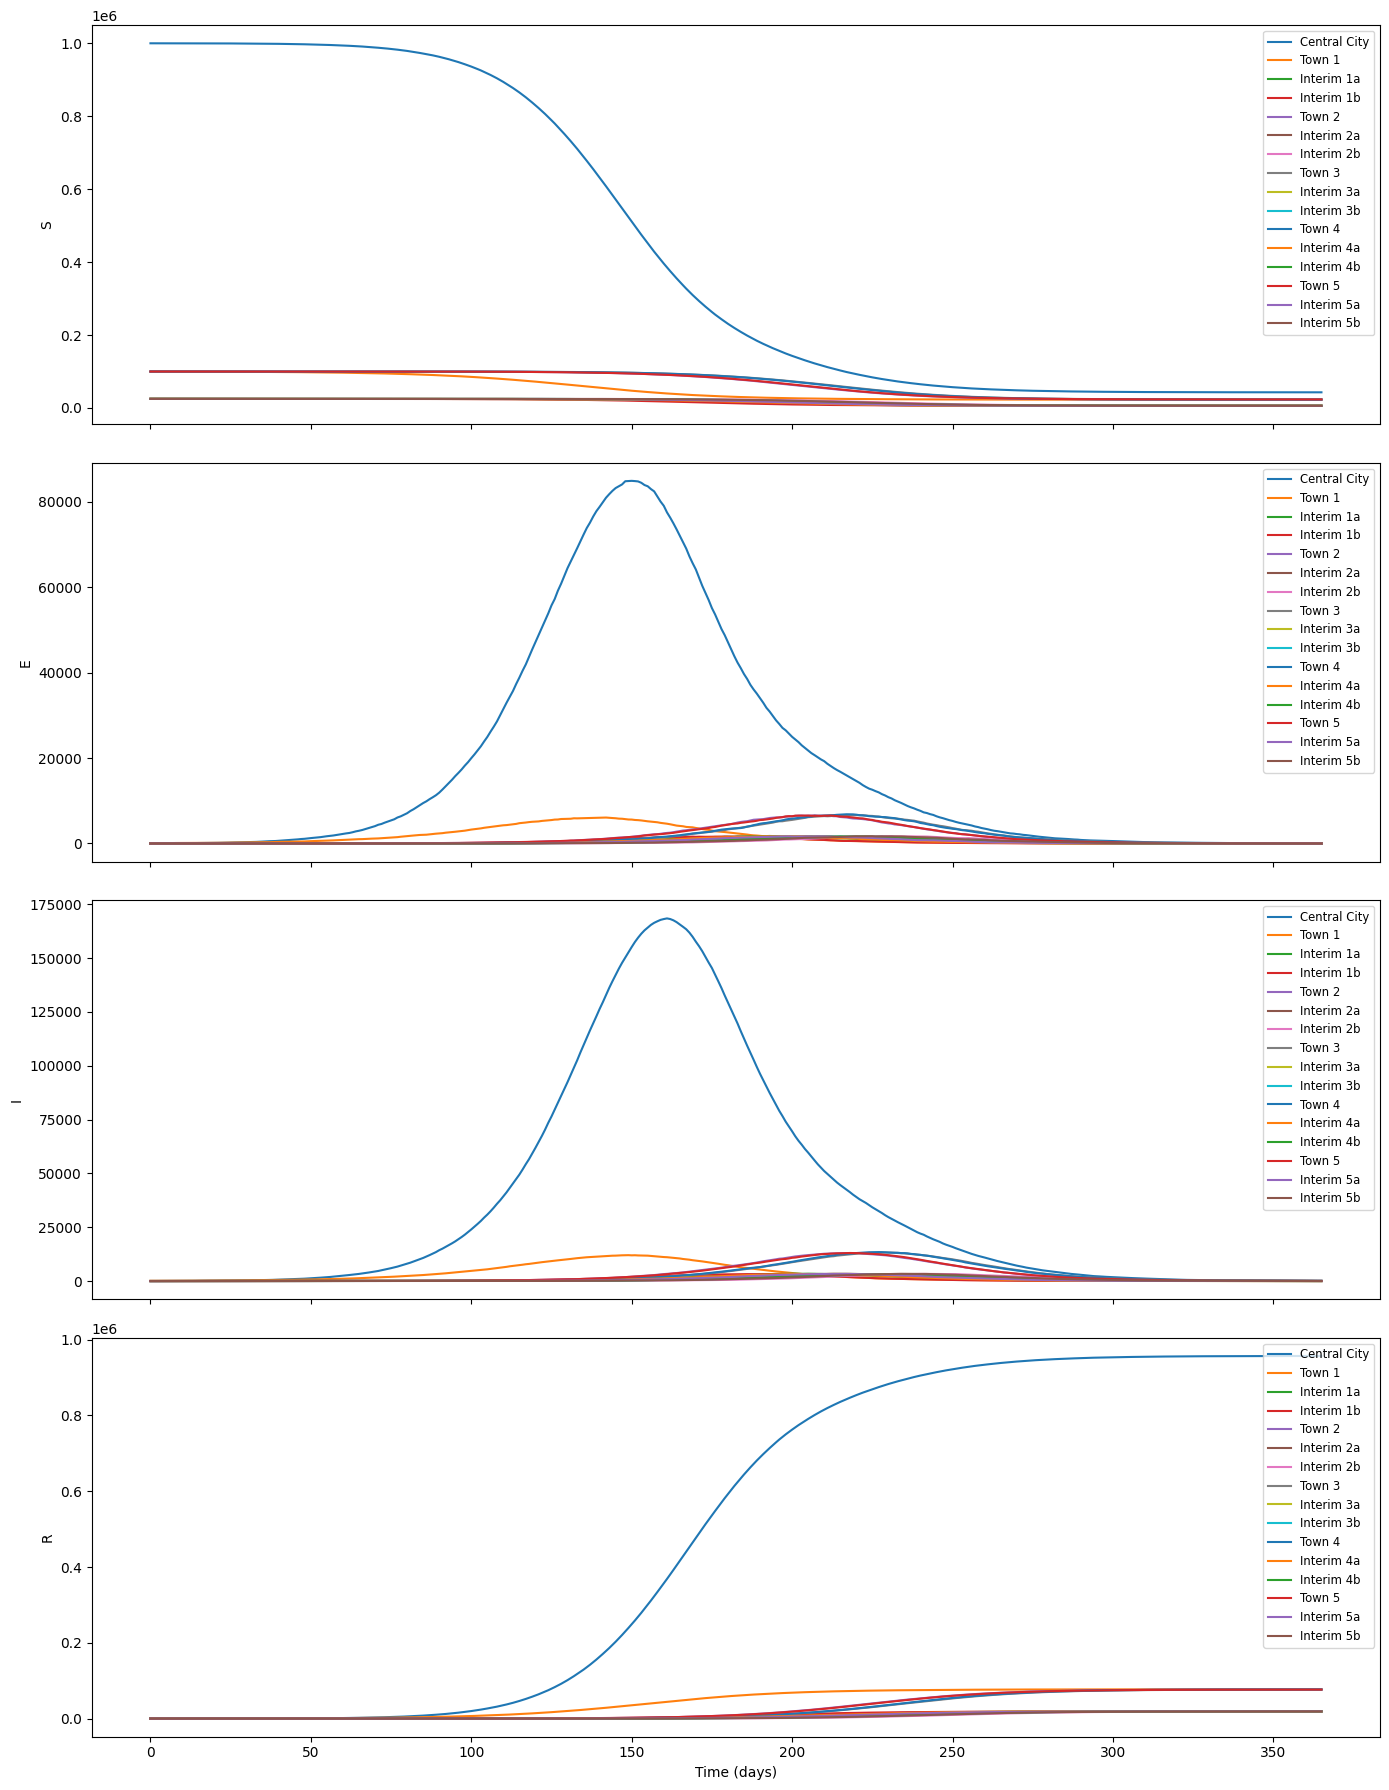

In [8]:
from laser.core import PropertySet
from laser.generic.models.model import Model
import laser.generic.models.SEIR as SEIR
from laser.core.distributions import normal

exp_mean = 7.0
exp_stddev = 1.0
inf_mean = 14.0
inf_stddev = 2.0
R0 = 2.0
beta = R0 / inf_mean

parameters = PropertySet({"nticks": 365, "beta": beta, "gravity_c": 2.5})
scenario["S"] = scenario.population
scenario["E"] = 0
scenario["I"] = 0
scenario["R"] = 0
scenario.loc[scenario.name == "Town 1", "S"] -= 100
scenario.loc[scenario.name == "Town 1", "I"] += 100
prj = scenario.to_crs(4326)
model = Model(prj, parameters)
incubation_distribution = normal(loc=exp_mean, scale=exp_stddev)
infectious_distribution = normal(loc=inf_mean, scale=inf_stddev)
model.components = [
    SEIR.Susceptible(model),
    SEIR.Recovered(model),
    SEIR.Infectious(model, infectious_distribution, 1),
    SEIR.Exposed(model, incubation_distribution, infectious_distribution, 1, 1),
    SEIR.Transmission(model, incubation_distribution, 1)
]
model.run()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 1, figsize=(14, 18), sharex=True)
compartments = ['S', 'E', 'I', 'R']

for idx, comp in enumerate(compartments):
    for node in scenario.index:
        axes[idx].plot(getattr(model.nodes, comp)[:, node], label=scenario.loc[node, "name"])
    axes[idx].set_ylabel(comp)
    axes[idx].legend(loc='upper right', fontsize='small')
axes[-1].set_xlabel("Time (days)")
plt.tight_layout()
plt.show()

In [9]:
# model.network


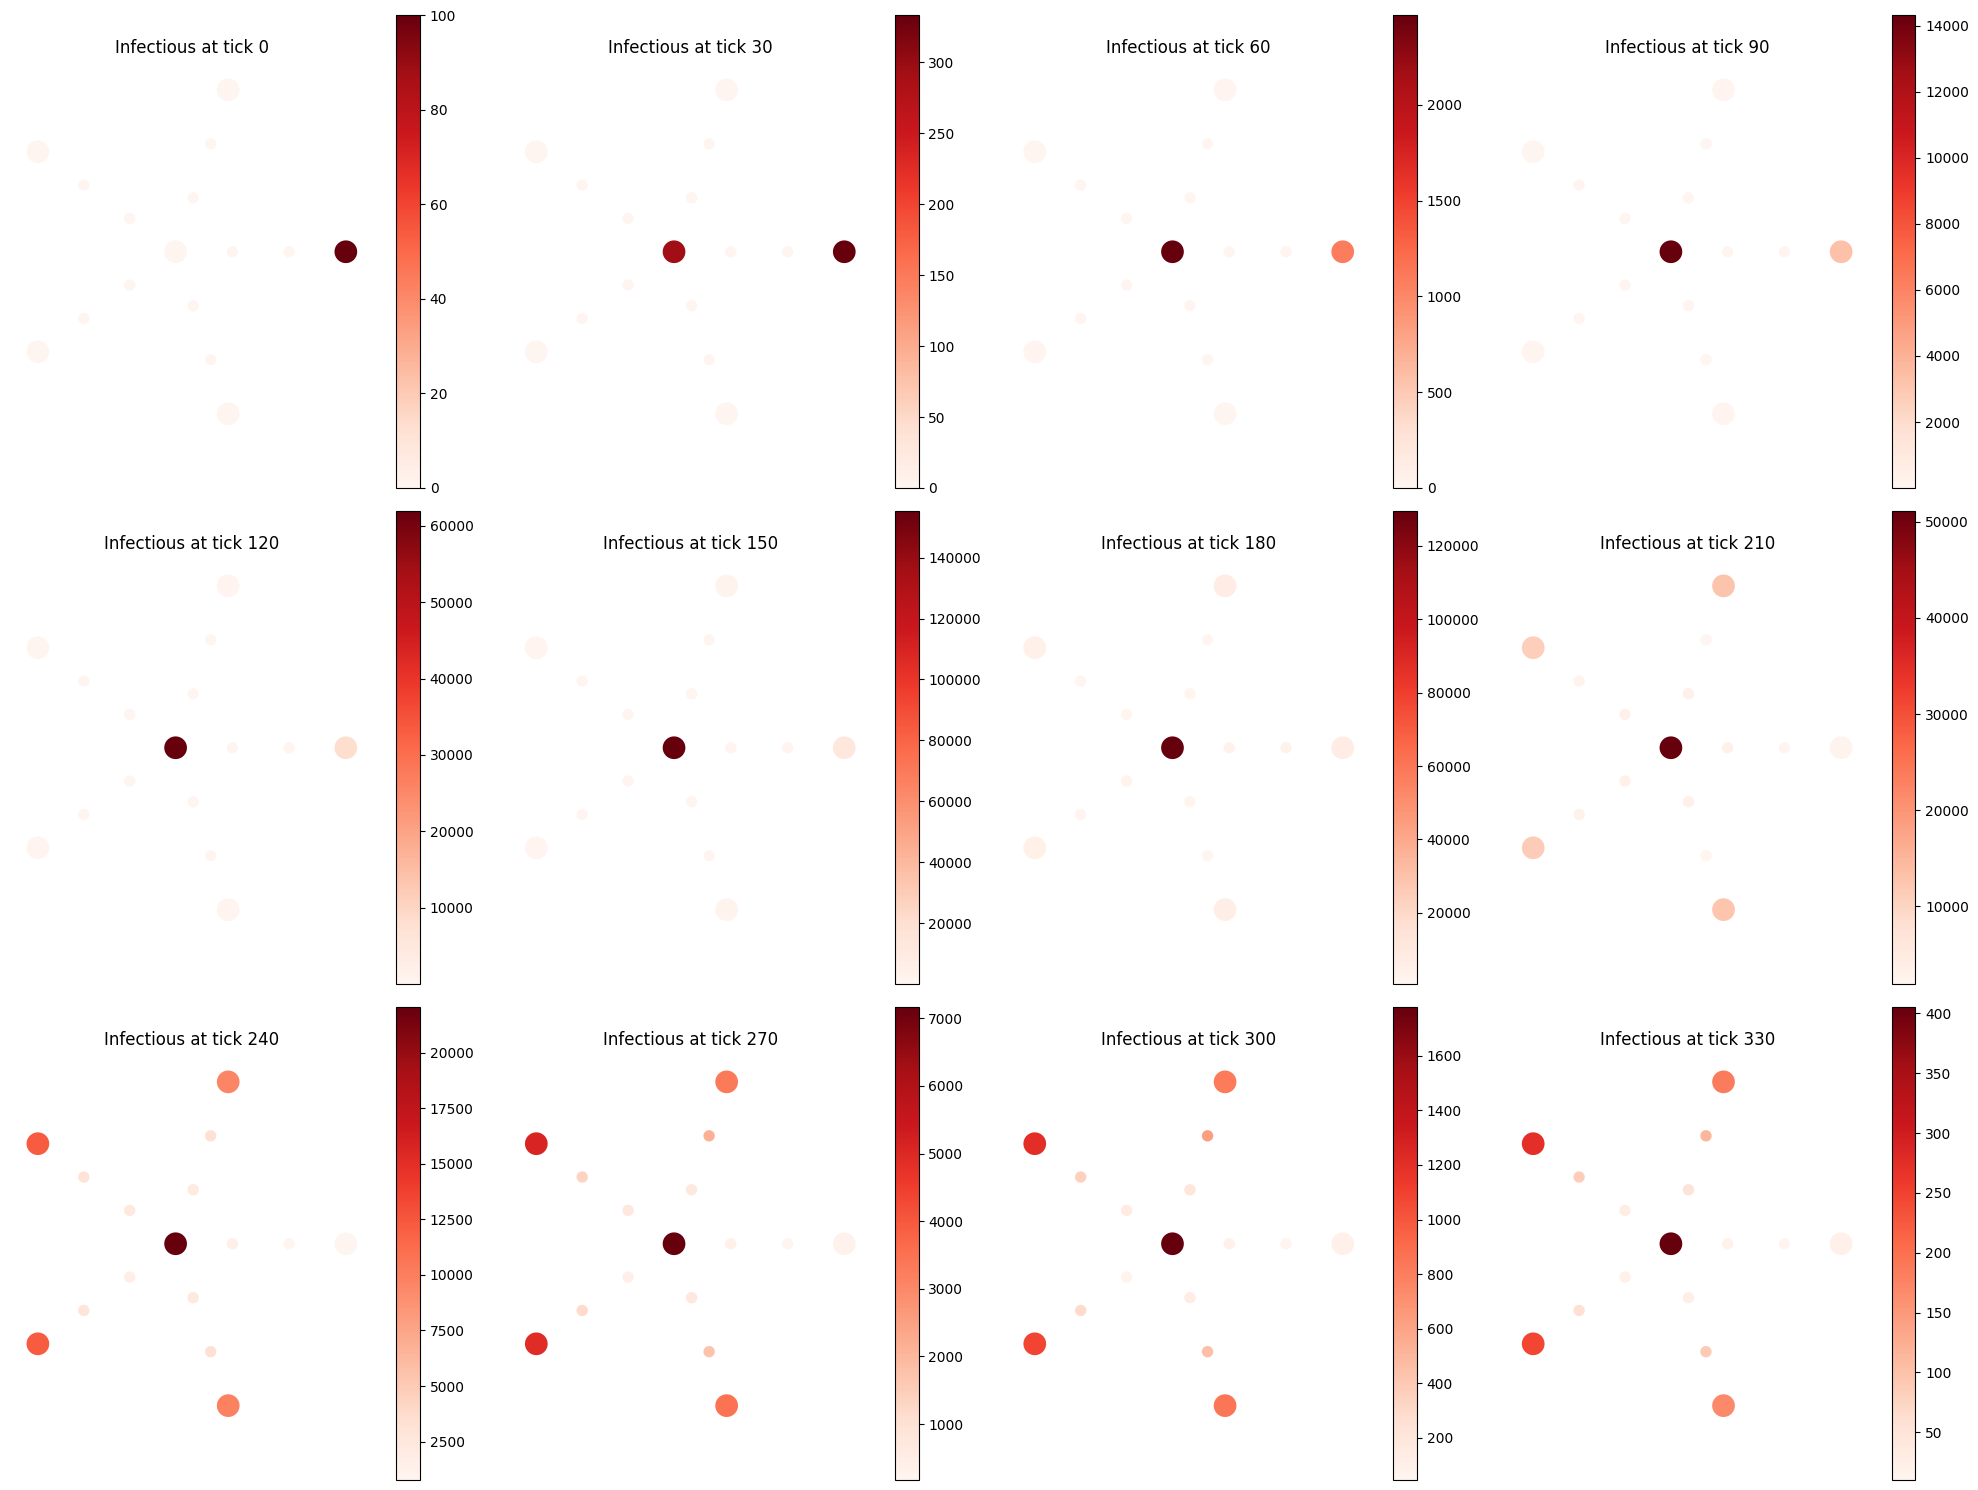

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
ticks = list(range(0, 361, 30))

for ax, tick in zip(axes.flat, ticks):
    prj["I_tick"] = model.nodes.I[tick, :] # / prj.population
    prj.plot(column="I_tick", cmap="Reds", legend=True, ax=ax)
    ax.set_title(f"Infectious at tick {tick}")
    ax.axis('off')

plt.tight_layout()
plt.show()